## Setup

In [10]:
# Get raw advent-of-code data
from aocd.models import Puzzle

puzzle = Puzzle(year=2025, day=10)
input_data = puzzle.input_data
example = puzzle.examples[0]

In [11]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

from common.utils.perf_check import check_time

## Part a


### Breadth-first search approach
We can see the lights as bits, and the desired light state as a bitmask, e.g. 0110 -> 6

Pressing a button twice cancels out, so we need to press each button either once or zero times.

Le's start by trying to figure out the smallest combination of lights to press to get to the desired state using a standard breadth-first search (BFS) algorithm.

In [24]:
# Imports
from collections import deque

In [729]:
# Functions
def parse_input(input_data: str) -> list[tuple[int, list[int], int]]:
    """Parse input data into a list of target light states and buttons, both stored as bitmasks."""
    machines = []
    for line in input_data.splitlines():
        # Break up the string
        lights_str, *button_strs, _ = (part[1:-1] for part in line.split())

        # Parse lights and buttons into bitmask
        n_lights = len(lights_str)
        target_bitmask = sum(1 << i for i, c in enumerate(lights_str) if c == "#")
        button_bitmasks = [sum(1 << int(toggle) for toggle in b.split(",")) for b in button_strs]

        # Save values to machine tuple
        machines.append((target_bitmask, button_bitmasks, n_lights))

    return machines


def min_presses_bfs(lights_target: int, buttons: list[int]) -> int:
    """Find the minimum number of presses for a desired light state using BFS.

    Note that we only need to press a button at most once, so we can just go through the buttons
    in order to reduce the state space.
    """
    # Standard BFS queue starting at state 0 (all lights off)
    q = deque([0])

    # Track seen states: {light_state: minimum_presses_to_reach_it}
    seen_states = {0: 0}

    while q:
        # Unpack the next state in the queue
        current_state = q.popleft()

        # The number of presses it took to get to the current light configuration
        n_presses = seen_states[current_state]

        # If we've run out of buttons to check for this path, stop
        if n_presses >= len(buttons):
            continue

        for b in buttons:
            # 'Press' the button (XOR toggles all bits in the button)
            next_state = current_state ^ b

            if next_state not in seen_states:
                # Check if we match the target light state
                if next_state == lights_target:
                    # If so, return the number of presses it took
                    return n_presses + 1

                # Otherwise add the next state and number of presses to the seen tracker
                seen_states[next_state] = n_presses + 1

                # And keep searching from this new configuration
                q.append(next_state)

    err_msg = f"Light state {lights_target} not reachable with buttons {buttons}."
    raise ValueError(err_msg)


def solve_a_bfs(input_data: str) -> int:
    """Find the sum of the minimum number of presses for each machine using a BFS algorithm."""
    return sum(min_presses_bfs(lights_target, buttons) for lights_target, buttons, _ in parse_input(input_data))


In [730]:
# Correctness check
str(solve_a_bfs(example.input_data)) == example.answer_a

True

In [134]:
# Performance check
bfs_time_a = check_time(solve_a_bfs, input_data)
print(f"The BFS approach takes {bfs_time_a:.1f} ms per run.")


The BFS approach takes 3.5 ms per run.


### Iterative combinatorial approach
Knowing that we only need to press each button at most once, we can also use a layered search through all button combinations, starting with combinations of 1 buttons, then, 2 ... up to n buttons.

In [ ]:
# Imports
from itertools import combinations

In [801]:
# Functions
def min_presses_iter(lights_target: int, buttons: list[int]) -> int:
    """Find the minimum number of presses for a desired light state by iterating through button combinations."""
    # Iterate through the number of buttons to press
    for n in range(len(buttons) + 1):
        # Iterate through all button combinations for n
        for button_combo in combinations(buttons, n):
            current_state = 0
            # 'Press' all buttons by XOR'ing
            for button in button_combo:
                current_state ^= button

            # Return if the resulting state matches the target state
            if current_state == lights_target:
                return n

    err_msg = f"Light state {lights_target} not reachable with buttons {buttons}."
    raise ValueError(err_msg)


def solve_a_iter(input_data: str) -> int:
    """Find the sum of the minimum number of presses for each machine using an iterative combinatorial approach."""
    return sum(min_presses_iter(lights_target, buttons) for lights_target, buttons, _ in parse_input(input_data))

In [802]:
# Correctness check
str(solve_a_iter(example.input_data)) == example.answer_a

True

In [701]:
# Performance check
iter_time_a = check_time(solve_a_iter, input_data)
print(f"The iterative approach takes {iter_time_a:.1f} ms per run.")
print(f"This is {bfs_time_a / iter_time_a:.1f} x faster than the BFS approach.")


The iterative approach takes 2.2 ms per run.
This is 1.6 x faster than the BFS approach.


### Linear algebra
The iterative approach works fine, but I feel like we can be more analytical. Linear algebra it is! 

If we see the light state as a target vector `l` and the buttons as a matrix `B`, we can see the amount of presses per button as `x`, and we need to solve:
```
A * x = b
```

However, we need to ensure the whole system is modulo 2, i.e. all numbers can only be 0 or 1. For this, we can use Galois Fields; specifically the Galois Field of two elements (GF(2)). We need to perform Gaussian Elimination (GE) to find the smallest solution in this GF(2) space.

Disclaimer: this is quite complex and I mostly just adapted existing implementations of the GF(2) GE algorithm , described here: https://www.cs.umd.edu/~gasarch/TOPICS/factoring/fastgauss.pdf

In [697]:
# Functions
def build_augmented_matrix(lights_target: int, buttons: list[int], n_lights: int) -> list[int]:
    """Build augmented matrix for GF(2) system: rows are lights, columns are buttons + target."""
    m = len(buttons)
    rows = []

    for i in range(n_lights):
        row = 0
        for j, b_mask in enumerate(buttons):
            if (b_mask >> i) & 1:
                row |= 1 << j  # Button j affects Light i
        if (lights_target >> i) & 1:
            row |= 1 << m  # Light i needs to be ON
        rows.append(row)

    return rows


def gaussian_elimination_gf2(rows: list[int], n_buttons: int, n_lights: int) -> tuple[list[int], list[int]]:
    """Perform Gaussian Elimination in GF(2). Returns pivot_cols and rows."""
    pivot_row = 0
    pivot_cols = []

    for j in range(n_buttons):
        if pivot_row >= n_lights:
            break

        # Find pivot row with 1 in column j
        sel = next((i for i in range(pivot_row, n_lights) if (rows[i] >> j) & 1), None)
        if sel is None:
            continue  # Free variable

        # Swap and eliminate
        rows[pivot_row], rows[sel] = rows[sel], rows[pivot_row]

        # XOR this row into all other rows to clear column j
        for i in range(n_lights):
            if i != pivot_row and (rows[i] >> j) & 1:
                rows[i] ^= rows[pivot_row]

        pivot_cols.append(j)
        pivot_row += 1

    return pivot_cols, rows


def solve_for_free_variables(rows: list[int], pivot_cols: list[int], n_buttons: int) -> int:
    """Brute force all free variable combinations and find minimum presses."""
    free_cols = [j for j in range(n_buttons) if j not in pivot_cols]
    best_presses = float("inf")

    for i in range(1 << len(free_cols)):
        current_press_mask = 0

        # Set free variables
        for idx, col in enumerate(free_cols):
            if (i >> idx) & 1:
                current_press_mask |= 1 << col

        # Solve for pivot variables
        for r_idx, p_col in enumerate(pivot_cols):
            target_bit = (rows[r_idx] >> n_buttons) & 1
            free_vars_xor_sum = (rows[r_idx] & current_press_mask).bit_count() % 2

            if target_bit ^ free_vars_xor_sum:
                current_press_mask |= 1 << p_col

        best_presses = min(best_presses, (current_press_mask).bit_count())

    if best_presses == float("inf"):
        msg = "No valid solution found."
        raise ValueError(msg)

    return int(best_presses)


def min_presses_gf2(lights_target: int, buttons: list[int], n_lights: int) -> int:
    """Find minimum button presses using Gaussian Elimination in GF(2) field."""
    m = len(buttons)

    # Build and solve system
    rows = build_augmented_matrix(lights_target, buttons, n_lights)
    pivot_cols, rows = gaussian_elimination_gf2(rows, m, n_lights)

    return solve_for_free_variables(rows, pivot_cols, m)


def solve_a_gf2(input_data: str) -> int:
    """Find the sum of the minimum number of presses for each machine using Gaussian Elimination in the GF(2) field."""
    return sum(
        min_presses_gf2(lights_target, buttons, n_lights)
        for lights_target, buttons, n_lights in parse_input(input_data)
    )

In [695]:
# Correctness check
str(solve_a_gf2(example.input_data)) == example.answer_a

True

In [698]:
# Performance check
gf2_time_a = check_time(solve_a_gf2, input_data)
print(f"The GF2 GE approach takes {gf2_time_a:.1f} ms per run.")
print(
    f"This is {bfs_time_a / gf2_time_a:.1f} x faster than the BFS approach"
    f" and {iter_time_a / gf2_time_a:.1f} x faster than the iterative approach."
)


The GF2 GE approach takes 2.5 ms per run.
This is 1.4 x faster than the BFS approach and 0.9 x faster than the iterative approach.


In [123]:
# Submit answer
puzzle.answer_a = solve_a_gf2(input_data)

That's the right answer!  You are one gold star closer to decorating the North Pole. [Continue to Part Two]


### Extra: benchmarking over larger problem sizes

With the given input, these are the performances:

| Approach  | Time (ms) | Speedup vs BFS |
|-----------|-----------|----------------|
| BFS       | 3.5       | 1.0x           |
| Iterative | 2.2       | 1.6x           |
| GF2 GE    | 2.6       | 1.4x           |

As it turns out, going analytical is not worth it for inputs of this size. I'm curious to see how that changes for larger button lists.

I will randomly generate buttons for a given number of lights and randomly mix them in with the set of buttons that is guaranteed to reach the target light state.



#### Set up sensitivity analysis

In [512]:
# Imports
from enum import Enum
from random import betavariate, randint, sample
from typing import TYPE_CHECKING

import matplotlib.pyplot as plt
import numpy as np

if TYPE_CHECKING:
    from collections.abc import Callable

In [ ]:
# Functions
def gen_target(buttons: list[int], *, favor_fewer_presses: bool = True) -> int:
    """Generate a random target state that is guaranteed to be reachable with the given buttons."""
    lights_target = 0

    # Slightly favor fewer buttons being pressed, to match observed input distribution
    n_presses = int(betavariate(1.37, 1.42) * len(buttons)) if favor_fewer_presses else randint(1, len(buttons))
    for button in sample(buttons, n_presses):
        lights_target ^= button

    if lights_target == 0:
        # Regenerate if we get the trivial target state of 0
        return gen_target(buttons)

    return lights_target


def gen_new_input(
    n_machines: int = 151,
    n_lights_range: tuple[int, int] = (4, 10),
    n_buttons_range: tuple[int, int] | None = None,
    *,
    favor_fewer_presses: bool = True,
) -> list[tuple[int, list[int], int]]:
    """Generate new input data with random machines for testing performance with larger button sets."""
    machines = []
    for _ in range(n_machines):
        n_lights = randint(*n_lights_range)

        # Generate number of buttons on range if provided, else scale with number of lights.
        # From the input data we observe that n_buttons is typically around n_lights - 2 to n_lights +3
        n_buttons = (
            randint(*n_buttons_range) if n_buttons_range is not None else randint(max(2, n_lights - 2), n_lights + 3)
        )

        # Generate random buttons and solvable target state
        buttons = [randint(1, 1 << n_lights) for _ in range(n_buttons)]
        lights_target = gen_target(buttons, favor_fewer_presses=favor_fewer_presses)

        machines.append((lights_target, buttons, n_lights))

    return machines


class MinPressesAlgo(Enum):
    """Enum for algorithms with callable and arity."""

    BFS = (min_presses_bfs, False)
    ITER = (min_presses_iter, False)
    GF2 = (min_presses_gf2, True)

    @property
    def fn(self) -> Callable[..., int]:
        return self.value[0]

    @property
    def needs_n_lights(self) -> bool:
        return self.value[1]


def benchmark_approach(
    algo: MinPressesAlgo,
    numerical_input: list[tuple[int, list[int], int]],
) -> int:
    """Benchmark any min_presses function with numerical input data."""
    if algo.needs_n_lights:
        return sum(algo.fn(lights_target, buttons, n_lights) for lights_target, buttons, n_lights in numerical_input)
    return sum(algo.fn(lights_target, buttons) for lights_target, buttons, _ in numerical_input)


def benchmark_for_params(
    n_machines: int = 151,
    n_lights_range: tuple[int, int] = (2, 10),
    *,
    n_buttons_range: tuple[int, int] | None = None,
    n_unique_inputs: int = 1,
    n_time_checks: int = 3,
    n_time_repeats: int = 3,
) -> dict[str, float]:
    """Benchmark the algorithms for given parameters."""
    results = {}
    for _ in range(n_unique_inputs):
        # Generate new input data
        numerical_input = gen_new_input(n_machines, n_lights_range, n_buttons_range)

        for algo in MinPressesAlgo:
            # Time the approach
            time_taken = check_time(
                benchmark_approach, algo, numerical_input, number=n_time_checks, repeat_times=n_time_repeats
            )
            # Store result
            results.setdefault(algo.name, []).append(time_taken)

    # Average results over unique inputs
    for algo, times in results.items():
        results[algo] = sum(times) / len(times)

    return results


#### On the distribution of minimum button presses
Looking at the input data, we can see that it is not entirely random, or at least not uniform.

While the amount of buttons in the input data seems to be fairly uniformly distributed between -2 and +2 around the number of lights, the minimum amount of button presses to reach the target light state seems to skew towards lower numbers of presses.

We will account for this in the benchmark by drawing the number of buttons to form the target light state from a similar distribution as observed in the input data. The following distribution was found to fit the observed data well after some visual inspection:

```python
n_presses = int(betavariate(1.37, 1.42) * n_lights)
```

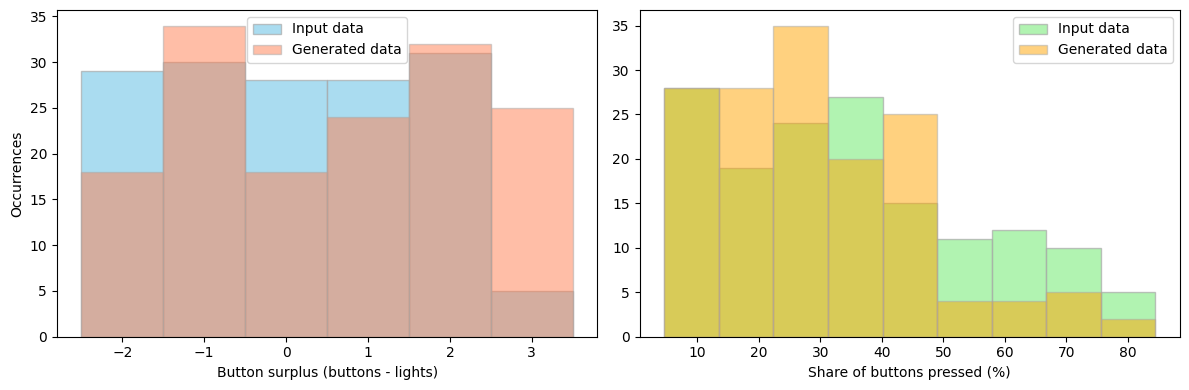

In [666]:
def extract_distributions(data: list[tuple[int, list[int], int]]) -> tuple[list, list]:
    """Extract button surplus and press share from parsed data."""
    pressed_shares, buttons_minus_lights = zip(
        *[
            (100 * min_presses_iter(lights_target, buttons) / len(buttons), len(buttons) - n_lights)
            for lights_target, buttons, n_lights in data
        ],
        strict=True,
    )
    return list(pressed_shares), list(buttons_minus_lights)


def plot_distributions_comparison(input_data: str, gen_data: list[tuple[int, list[int], int]]) -> None:
    """Plot button surplus and press share for input and generated data."""
    # Extract data
    input_pressed, input_surplus = extract_distributions(parse_input(input_data))
    gen_pressed, gen_surplus = extract_distributions(gen_data)

    _, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Button surplus
    axes[0].hist(
        input_surplus,
        bins=range(min(input_surplus), max(input_surplus) + 2),
        align="left",
        edgecolor="darkgray",
        color="skyblue",
        alpha=0.7,
        label="Input data",
    )
    axes[0].hist(
        gen_surplus,
        bins=range(min(gen_surplus), max(gen_surplus) + 2),
        align="left",
        edgecolor="darkgray",
        color="coral",
        alpha=0.5,
        label="Generated data",
    )
    axes[0].set_xlabel("Button surplus (buttons - lights)")
    axes[0].set_ylabel("Occurrences")
    axes[0].legend()

    # Press share
    min_press_share = min(*input_pressed, *gen_pressed)
    max_press_share = max(*input_pressed, *gen_pressed)
    axes[1].hist(
        input_pressed,
        bins=np.linspace(min_press_share, max_press_share, num=10),
        align="left",
        edgecolor="darkgray",
        color="lightgreen",
        alpha=0.7,
        label="Input data",
    )
    axes[1].hist(
        gen_pressed,
        bins=np.linspace(min_press_share, max_press_share, num=10),
        align="left",
        edgecolor="darkgray",
        color="orange",
        alpha=0.5,
        label="Generated data",
    )
    axes[1].set_xlabel("Share of buttons pressed (%)")
    axes[1].legend()

    plt.tight_layout()
    plt.show()
    plt.close()


# Generate and plot
gen_data = gen_new_input(n_machines=151)
plot_distributions_comparison(input_data, gen_data)

##### Trying to fit a betavariate distribution

I tried to fit a beta distribution to the observed data, but the fit was not very good. Hence I just visually inspected and tweaked the parameters until it looked about right.

"Beta distribution fit:")
    a (alpha): 0.908
    b (beta): 2.047
    loc: 0.100
    scale: 0.860
    


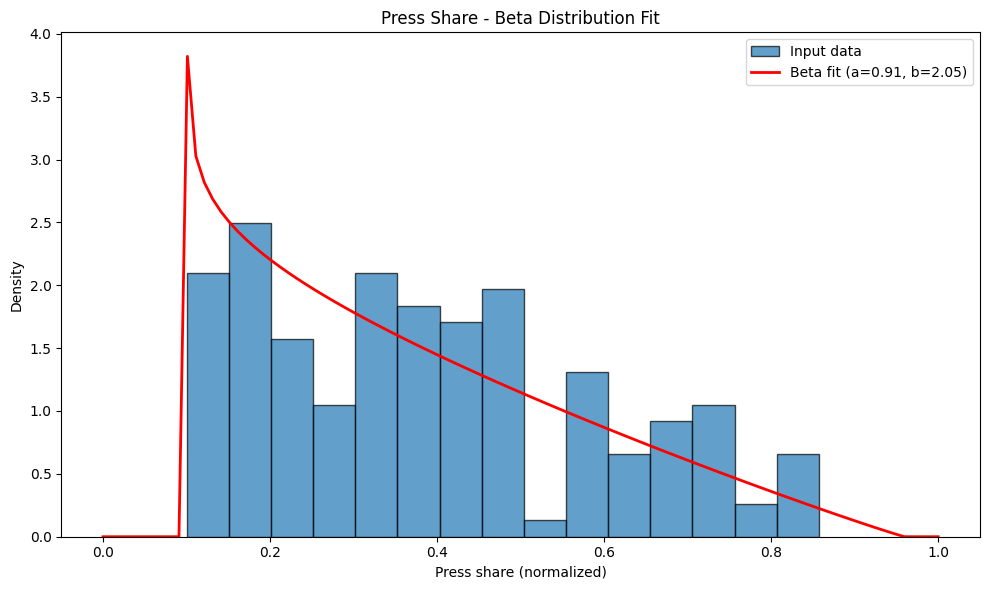

In [669]:
from scipy.stats import beta

# Extract the data you want to fit
input_pressed, input_surplus = extract_distributions(parse_input(input_data))

# Normalize pressed_shares to [0, 1] range for beta distribution
pressed_normalized = (np.array(input_pressed)) / 100

# Fit beta distribution
a, b, loc, scale = beta.fit(pressed_normalized)

print(f""""Beta distribution fit:")
    a (alpha): {a:.3f}
    b (beta): {b:.3f}
    loc: {loc:.3f}
    scale: {scale:.3f}
    """)

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 6))

# Histogram of actual data
ax.hist(pressed_normalized, bins=15, density=True, alpha=0.7, label="Input data", edgecolor="black")

# Fitted beta PDF
x = np.linspace(0, 1, 100)
ax.plot(x, beta.pdf(x, a, b, loc, scale), "r-", linewidth=2, label=f"Beta fit (a={a:.2f}, b={b:.2f})")

ax.set_xlabel("Press share (normalized)")
ax.set_ylabel("Density")
ax.set_title("Press Share - Beta Distribution Fit")
ax.legend()
plt.tight_layout()
plt.show()

#### Sense check: scale machines

The algorithm performance should not be affected by the number of machines (only the number of lights and buttons matter). Let's sense check that.

In [670]:
s_analysis_machines = {}

machine_counts = np.unique(np.logspace(1, 4, num=10, dtype=int))
for i in machine_counts:
    results = benchmark_for_params(
        n_machines=i,
        # Fewer unique inputs for larger machine counts to save time
        n_unique_inputs=int(np.ceil(10 ** (4.1 - np.log10(i)))),
        n_time_checks=5,
        n_time_repeats=5,
    )
    for algo, time in results.items():
        s_analysis_machines.setdefault(algo, []).append(time)

In [671]:
# Convert lists to numpy arrays and print statistics
for algo, times in s_analysis_machines.items():
    s_analysis_machines[algo] = np.array(times)
    speedup_str = (
        f", {np.average(s_analysis_machines['BFS'] / s_analysis_machines[algo]):.1f} x faster than BFS."
        if algo != "BFS"
        else "."
    )

    print(
        f"{algo:<4} - Average time per machine: "
        f"{np.average(s_analysis_machines[algo] / machine_counts) * 1e3:.1f} μs{speedup_str}"
    )

BFS  - Average time per machine: 14.6 μs.
ITER - Average time per machine: 8.8 μs, 1.7 x faster than BFS.
GF2  - Average time per machine: 11.7 μs, 1.3 x faster than BFS.


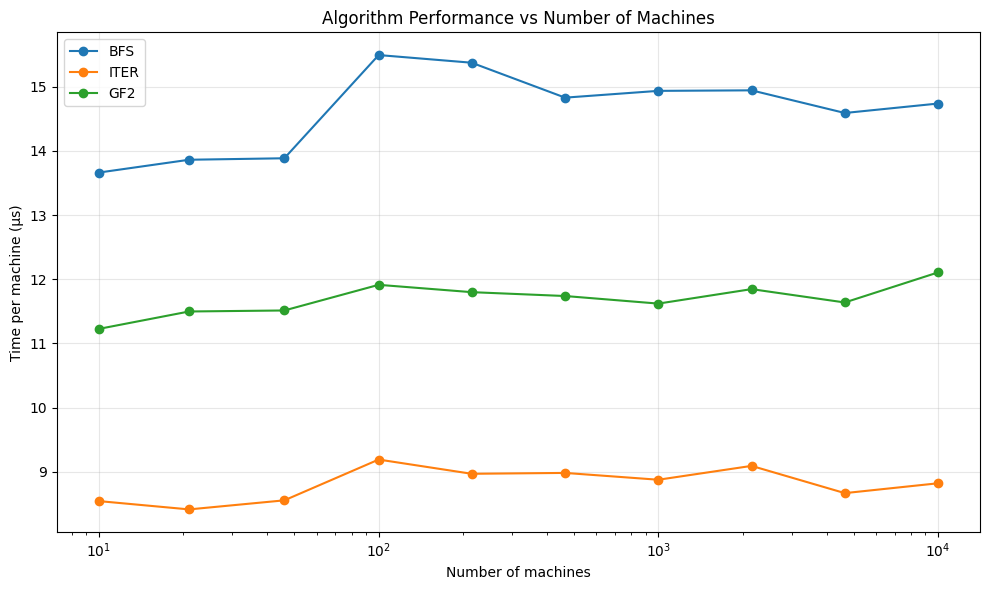

In [672]:
# Create plot
plt.figure(figsize=(10, 6))
for algo, times in s_analysis_machines.items():
    plt.plot(machine_counts, times * 1e3 / machine_counts, marker="o", label=algo)
plt.xlabel("Number of machines")
plt.ylabel("Time per machine (μs)")
plt.title("Algorithm Performance vs Number of Machines")
plt.legend()
plt.grid(visible=True, alpha=0.3)
plt.xscale("log")
plt.tight_layout()
plt.show()
plt.close()


We can see that, as expected, the running time per machine doesn't significantly change with the number of machines.

The **iterative approach** is consistently the fastest at **8.8 μs** per machine, with **GF2 GE** at and **BFS** at  being roughly 33% and 66% slower at **11.7 μs** and **14.6 μs** per machine, respectively.

#### Sensitivity analysis on number of lights and buttons

Now we look at what happens when we increase the number of lights. This automatically increases the number of buttons, as those hover around the number of light ± 3.

I expect that as the number of buttons increases, the BFS and iterative approaches will become much slower as their search spaces grow exponentially, while the GE GF2 approach should scale more gracefully.

In [ ]:
# Generate many machines to ensure statistical significance
n_machines = 250
n_lights_range = range(5, 21)

s_analysis_n_lights = {}
for i in n_lights_range:
    results = benchmark_for_params(n_machines, (i, i))
    for algo, time in results.items():
        s_analysis_n_lights.setdefault(algo, []).append(time / n_machines)


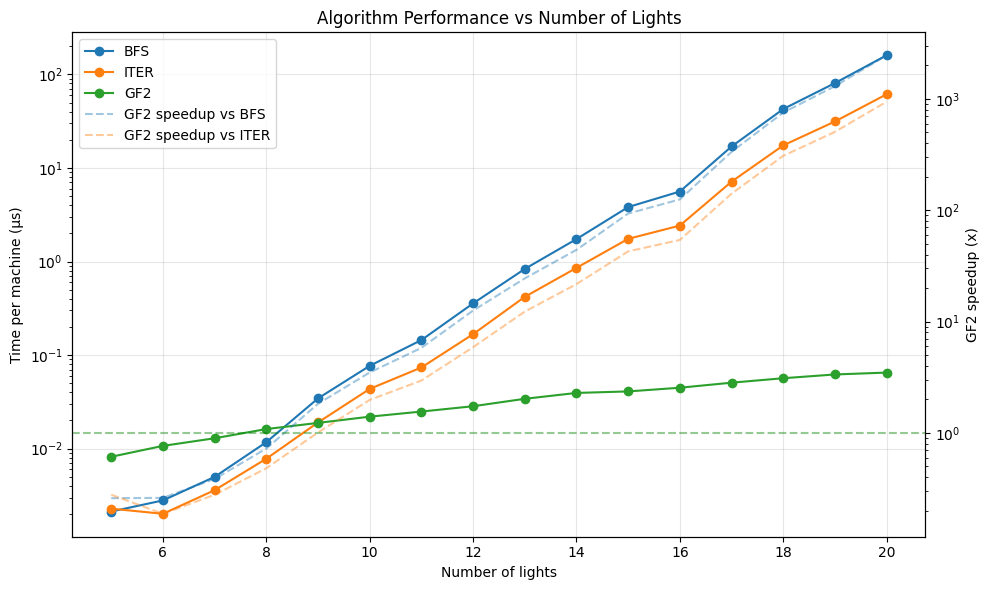

In [688]:
# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

# Primary axis: time per machine
for algo, times in s_analysis_n_lights.items():
    ax.plot(n_lights_range, times, marker="o", label=algo)
ax.set_xlabel("Number of lights")
ax.set_ylabel("Time per machine (μs)")
ax.set_yscale("log")
ax.set_title("Algorithm Performance vs Number of Lights")
ax.grid(visible=True, alpha=0.3)

# Secondary axis: GF2 speedup vs others
gf2_times = np.array(s_analysis_n_lights["GF2"])
ax2 = ax.twinx()
for algo, times in s_analysis_n_lights.items():
    if algo == "GF2":
        ax2.axhline(1.0, ls="--", c="green", alpha=0.42)
    else:
        ax2.plot(n_lights_range, np.array(times) / gf2_times, ls="--", alpha=0.42, label=f"GF2 speedup vs {algo}")
ax2.set_ylabel("GF2 speedup (x)")
ax2.set_yscale("log")

# Combined legend
h1, l1 = ax.get_legend_handles_labels()
if gf2_times.size:
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h1 + h2, l1 + l2, loc="upper left")
else:
    ax.legend(loc="upper left")

plt.tight_layout()
plt.show()
plt.close()


We can see that for small numbers of light (n < 9), the analytical approach is 2 - 4 times slower than the BFS or iterative approach. However, for n >= 9, it quickly becomes the fastest; at n = 20  it is roughly **1,000 to 2,500 times faster** than the BFS and iterative approaches, respectively. 

This makes sense as the search space for BFS and iterative approaches grows exponentially with the number of buttons, while the GE GF2 approach grows with a polynomial time complexity.

## Part b

### Linear algebra again

In part a, each light is binary, and pressing a button twice cancels out. That makes it so we can solve the problem in GF(2): XOR on bitmasks and Gaussian elimination over {0,1}.

In part b:
- Counters are integers (0, 1, 2, …), not bits.
- Pressing a button adds 1 to specific lights each time (no modulo 2).
- The goal is to solve A · x = b with x ≥ 0, minimizing sum(x).

So we need integer arithmetic, not module 2 / bitwise operations.

The solution space is much larger now, as each button can be pressed 0, 1, 2, … times. Let's start with a linear programming approach, and then later we can see how much longer combinatorial approaches take.

Model:
- A[i, j] = 1 if button j increments light i, else 0.
- x_j = number of times button j is pressed.
- b = target joltage per light
- Objective: minimize Σ x_j subject to A · x = b

We can use linear programming to solve the general problem, and speed it up by using the boundary condition that x ∈ ℕ^m, i.e. all x_j must be non‑negative integers.

In summary, we need to find:

\begin{aligned}
\min_{x \in \mathbb{N}^{m}} \quad & \sum_{j=1}^{m} x_j \\
\text{s.t.}\quad & A x = b
\end{aligned}


In [ ]:
# Imports
from scipy.optimize import Bounds, LinearConstraint, milp


In [ ]:
# Functions
def parse_input_b(input_data: str) -> list[tuple[tuple[int], list[set[int]]]]:
    """Parse input data into a list of buttons and joltage targets."""
    machines = []
    for line in input_data.splitlines():
        # Break up the string
        _, *button_strs, joltages_str = (part[1:-1] for part in line.split())

        # Parse into integers
        buttons = [{*map(int, b.split(","))} for b in button_strs]
        target_joltages = tuple(map(int, joltages_str.split(",")))

        # Save values to machine tuple
        machines.append((target_joltages, buttons))

    return machines


def min_presses_b_milp(joltage_target: tuple[int], buttons: list[set[int]]) -> int:
    """Find minimum button presses to reach joltage target using mixed-integer linear programming."""
    n_buttons = len(buttons)

    # Build coefficient matrix
    A = []  # noqa: N806 # Matrix names are capitalized
    for light_idx in range(len(joltage_target)):
        row = [1 if light_idx in button else 0 for button in buttons]
        A.append(row)

    # Objective: minimize sum of presses
    c = np.ones(n_buttons)

    # Constraints: A * x = joltage_target
    constraint = LinearConstraint(A, joltage_target, joltage_target)

    # Bounds: x >= 0, integer
    bounds = Bounds(lb=0)
    integrality = c  # 1 = integer variable

    result = milp(c=c, constraints=constraint, bounds=bounds, integrality=integrality)

    if not result.success:
        msg = f"Could not find solution for joltage target {joltage_target}"
        raise ValueError(msg)

    return int(result.fun)


def solve_b_linprog(input_data: str) -> int:
    """Find the total minimum number of presses to reach target joltages using mixed-integer linear programming."""
    return sum(min_presses_b_milp(joltage_target, buttons) for joltage_target, buttons in parse_input_b(input_data))


In [741]:
# Correctness check
str(solve_b_linprog(example.input_data)) == example.answer_b

True

In [742]:
# Performance check
linprog_time_b = check_time(solve_b_linprog, input_data, number=25)
print(f"The linprog approach takes {linprog_time_b:.1f} ms per run.")


The linprog approach takes 64.9 ms per run.


### Dynamic programming
We can also extend the dynamic pgramming approach from part a to this part b.

I expect this to be significantly slower than the linear programming approach, especially for larger inputs, as the search space grows exponentially with the number of buttons and the maximum number of presses per button.

Note that this is heavily inspired by this solution: https://old.reddit.com/r/adventofcode/comments/1pity70/2025_day_10_solutions/nt8vlv9/

I was mostly curious how much slower it would be compared to the linear programming approach.


In [792]:
# Imports
from collections import defaultdict
from functools import lru_cache
from itertools import combinations


In [823]:
# Functions
def min_presses_b_dp(joltage_target: tuple[int], buttons: list[set[int]]) -> int:
    """Find the minimum number of button presses to reach the joltage target using dynamic programming.

    Uses a divide-by-2 strategy with parity grouping to reduce the state space.
    """
    combos_by_parity, combo_increments = defaultdict(list), {}

    # Precompute all button combinations and group by their supply parity
    for n in range(len(buttons) + 1):
        for combo in combinations(range(len(buttons)), n):
            # Count how many times each light is pressed by this button combination
            increments = tuple(sum(light in buttons[b_idx] for b_idx in combo) for light in range(len(joltage_target)))

            # Group combinations by parity (odd/even) to enable divide-by-2 recursion
            parity = tuple(s % 2 for s in increments)

            combos_by_parity[parity].append(combo)
            combo_increments[combo] = increments

    @lru_cache(maxsize=1_000)
    def min_presses(target: tuple[int]) -> float:
        """Recursively find minimum presses for a target joltage state using divide-by-2 strategy with parity matching."""
        if any(t < 0 for t in target):
            return float("inf")
        if all(t == 0 for t in target):
            return 0

        # Find all button combos that match the target parity
        target_parity = tuple(t % 2 for t in target)
        return min(
            (
                len(combo)
                + 2 * min_presses(tuple((t - s) // 2 for t, s in zip(target, combo_increments[combo], strict=True)))
                for combo in combos_by_parity[target_parity]
            ),
            default=float("inf"),
        )

    result = min_presses(joltage_target)
    if result == float("inf"):
        msg = "No solution found"
        raise ValueError(msg)

    return int(result)


def solve_b_dp(input_data: str) -> int:
    """Find the total minimum number of presses to reach target joltages using dynamic programming."""
    return sum(min_presses_b_dp(joltage_target, buttons) for joltage_target, buttons in parse_input_b(input_data))

In [821]:
# Correctness check
str(solve_b_dp(example.input_data)) == example.answer_b

True

In [824]:
# Performance check
dp_time_b = check_time(solve_b_dp, input_data, number=25)
print(
    f"The dynamic programming approach takes {dp_time_b:.0f} ms per run, "
    f"{dp_time_b / linprog_time_b:.1f} x slower than the linear programming approach."
)


The dynamic programming approach takes 579 ms per run, 8.9 x slower than the linear programming approach.
